In [2]:
import numpy as np
import pandas as pd
import os
import pickle   
from statsmodels.stats.multitest import multipletests
import einops
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns

cmap = sns.color_palette("afmhot", as_cmap=True)

fuzzy_output_path = '../output/fuzzy_transformer_output_cross.pkl'
trans_output_path = '../output/transformer_output_cross.pkl'

fuzzy_output = pickle.load(open(fuzzy_output_path, 'rb'))
trans_output = pickle.load(open(trans_output_path, 'rb'))
print(fuzzy_output.keys(), trans_output.keys())



/data/xiaowjia/miniconda3/envs/dl_pl/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


dict_keys(['centers', 'res', 'embs', 'atts', 'data_info']) dict_keys(['res', 'embs', 'atts', 'data_info'])


In [10]:

# UMAP
import umap.umap_ as umap


fuzzy_res = fuzzy_output['res']
trans_res = trans_output['res']

emb_fuzzy = fuzzy_output['embs']
emb_trans = trans_output['embs']

label_fuzzy = fuzzy_res['label']
label_trans = trans_res['label']

print(emb_fuzzy.shape, emb_trans.shape, label_fuzzy.shape, label_trans.shape)

# UMAP

reducer = umap.UMAP()
embedding_fuzzy = reducer.fit_transform(emb_fuzzy)
reducer = umap.UMAP()
embedding_trans = reducer.fit_transform(emb_trans)






(8168, 80) (8168, 80) (8168,) (8168,)


/data/xiaowjia/miniconda3/envs/dl_pl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/data/xiaowjia/miniconda3/envs/dl_pl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/data/xiaowjia/miniconda3/envs/dl_pl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/data/xiaowjia/miniconda3/envs/dl_pl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

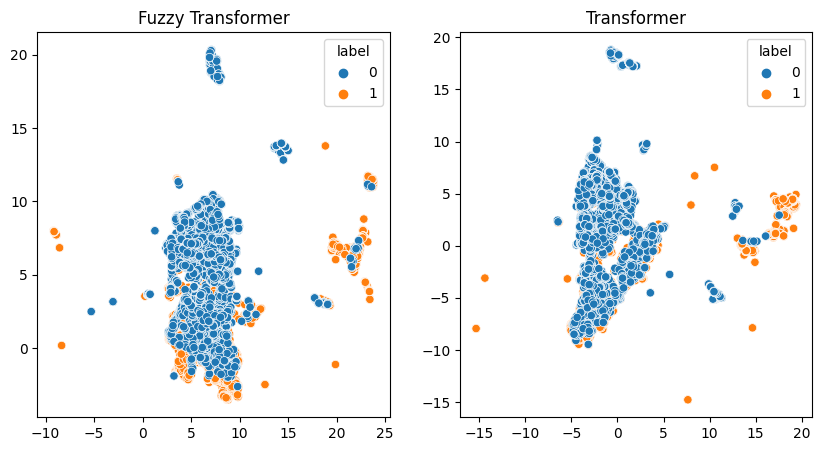

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
# plot the results and make the label as the color
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.scatterplot(x=embedding_fuzzy[:, 0], y=embedding_fuzzy[:, 1], hue=label_fuzzy, ax=ax[0], palette='tab10')
ax[0].set_title('Fuzzy Transformer')
sns.scatterplot(x=embedding_trans[:, 0], y=embedding_trans[:, 1], hue=label_trans, ax=ax[1], palette='tab10')
ax[1].set_title('Transformer')
plt.show()


# 四类

/data/xiaowjia/miniconda3/envs/dl_pl/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:7321: RuntimeWarning: invalid value encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/data/xiaowjia/miniconda3/envs/dl_pl/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:7313: RuntimeWarning: invalid value encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)


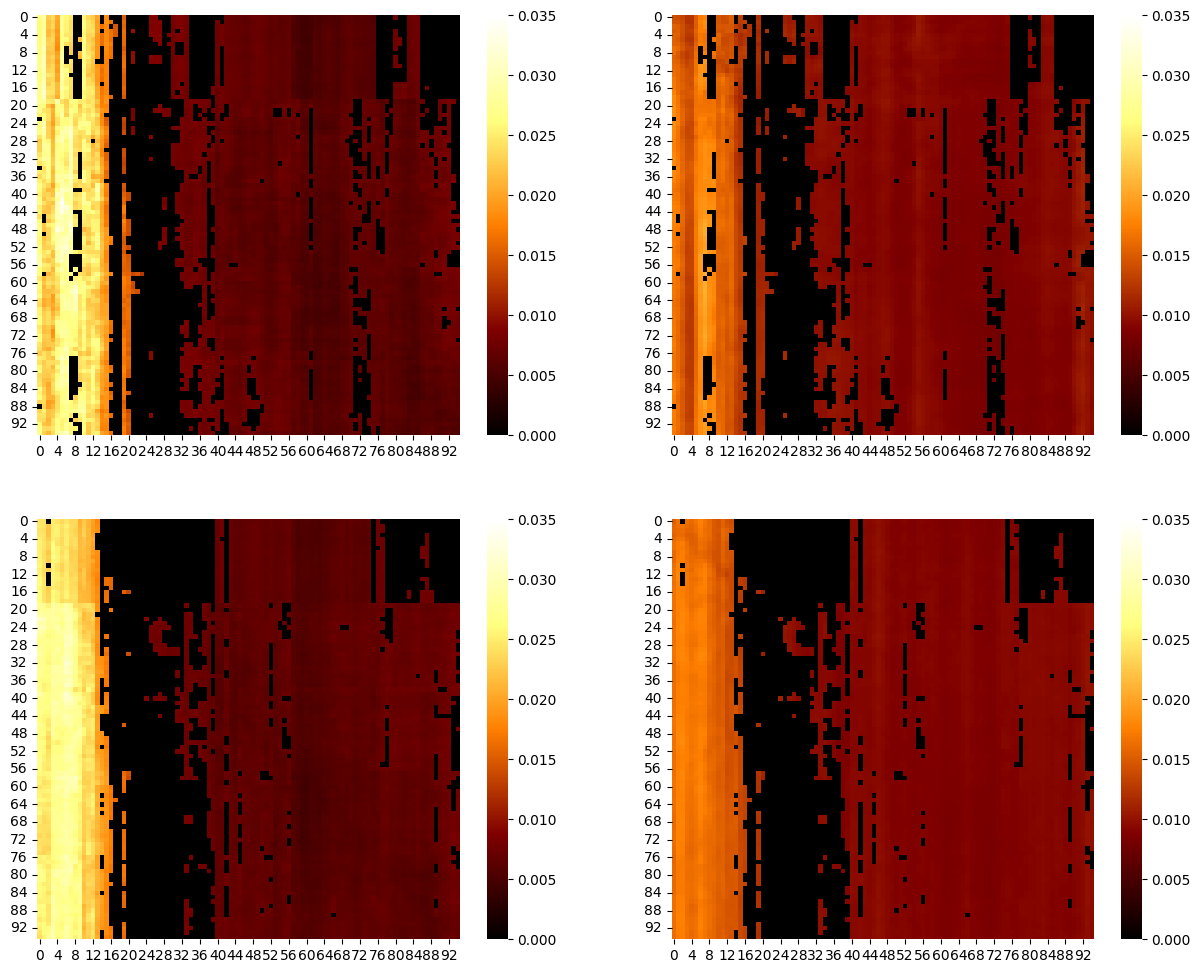

In [12]:
# Fuzzy-Right-Transformer-Wrong
# fdr correction
vmin, vmax = 0, 0.035
fuzzy_res = fuzzy_output['res']
trans_res = trans_output['res']

fuzzy_res['check'] = fuzzy_res['label'] == fuzzy_res['pred']
trans_res['check'] = trans_res['label'] == trans_res['pred']
# select which transformer model is incorrect and fuzzy model is correct. They are same length
fuzzy_res_right = fuzzy_res.loc[fuzzy_res['check'] == True].index
trans_res_wrong = trans_res.loc[trans_res['check'] == False].index

selected_idxes = np.intersect1d(fuzzy_res_right, trans_res_wrong)

trans_selected_atts = trans_output['atts'][selected_idxes].mean(axis=2)
fuzzy_selected_atts = fuzzy_output['atts'][selected_idxes].mean(axis=2)

# t-matrix
t_matrix = np.empty(trans_selected_atts.shape[1:])
p_matrix = np.empty(trans_selected_atts.shape[1:])
for i in range(95):
    for j in range(95):
        for k in range(2):
            stat = pg.ttest(trans_selected_atts[:,k,i,j], fuzzy_selected_atts[:,k,i,j])
            t_matrix[k,i,j] = stat['T'].values
            p_matrix[k,i,j] = stat['p-val'].values

p = einops.rearrange(p_matrix, 'k i j -> (k i j)')
reject, p_corrected, _, _ = multipletests(p, alpha=0.05, method='bonferroni')
p_corrected = einops.rearrange(p_corrected, '(k i j) -> k i j', k=2, i=p_matrix.shape[1], j=p_matrix.shape[2])
reject = einops.rearrange(reject, '(k i j) -> k i j', k=2, i=p_matrix.shape[1], j=p_matrix.shape[2])
mask = reject.astype(int)
plt.figure(figsize=(15, 12))
ax = plt.subplot(2, 2, 1)
sns.heatmap(fuzzy_selected_atts[:,0].mean(0)*mask[0], ax=ax, vmin=vmin, vmax=vmax, cmap=cmap)
ax = plt.subplot(2, 2, 2)
sns.heatmap(trans_selected_atts[:,0].mean(0)*mask[0], ax=ax, vmin=vmin, vmax=vmax, cmap=cmap)
ax = plt.subplot(2, 2, 3)
sns.heatmap(fuzzy_selected_atts[:,1].mean(0)*mask[1], ax=ax, vmin=vmin, vmax=vmax, cmap=cmap)
ax = plt.subplot(2, 2, 4)
sns.heatmap(trans_selected_atts[:,1].mean(0)*mask[1], ax=ax, vmin=vmin, vmax=vmax, cmap=cmap)

plt.savefig('../output/fuzzy-right-transformer-wrong.svg')

/data/xiaowjia/miniconda3/envs/dl_pl/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:7321: RuntimeWarning: invalid value encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/data/xiaowjia/miniconda3/envs/dl_pl/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:7313: RuntimeWarning: invalid value encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)
/data/xiaowjia/miniconda3/envs/dl_pl/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:7321: RuntimeWarning: invalid value encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/data/xiaowjia/miniconda3/envs/dl_pl/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:7313: RuntimeWarning: invalid value encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)
/data/xiaowjia/miniconda3/envs/dl_pl/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:7321: RuntimeWarning: invalid value encountered in _nct_sf
 

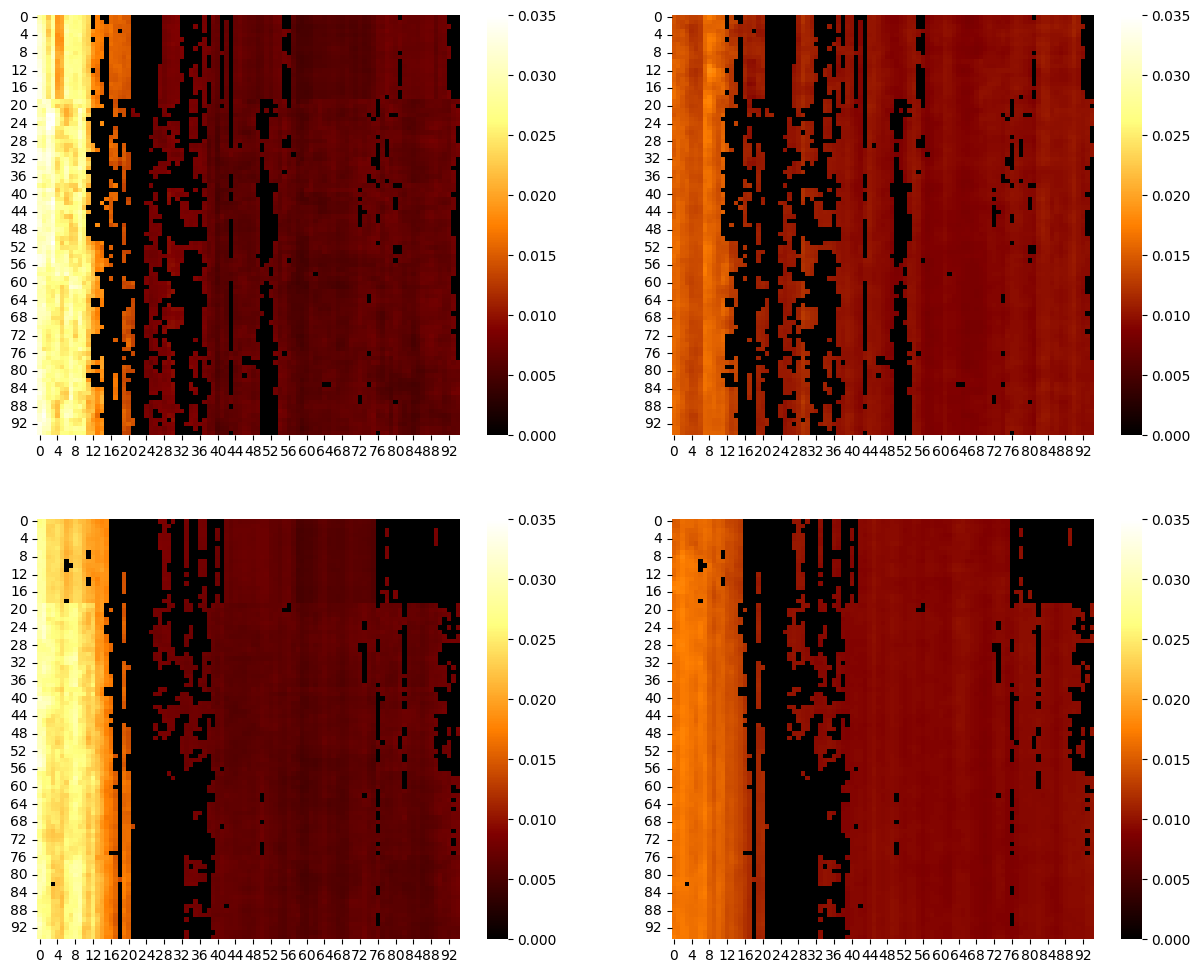

In [13]:
# Fuzzy-Wrong-Transformer-Right

vmin, vmax = 0, 0.035
fuzzy_res = fuzzy_output['res']
trans_res = trans_output['res']

fuzzy_res['check'] = fuzzy_res['label'] == fuzzy_res['pred']
trans_res['check'] = trans_res['label'] == trans_res['pred']
# select which transformer model is incorrect and fuzzy model is correct. They are same length
fuzzy_res_right = fuzzy_res.loc[fuzzy_res['check'] == False].index
trans_res_wrong = trans_res.loc[trans_res['check'] == True].index

selected_idxes = np.intersect1d(fuzzy_res_right, trans_res_wrong)

trans_selected_atts = trans_output['atts'][selected_idxes].mean(axis=2)
fuzzy_selected_atts = fuzzy_output['atts'][selected_idxes].mean(axis=2)

# t-matrix
t_matrix = np.empty(trans_selected_atts.shape[1:])
p_matrix = np.empty(trans_selected_atts.shape[1:])
for i in range(95):
    for j in range(95):
        for k in range(2):
            stat = pg.ttest(trans_selected_atts[:,k,i,j], fuzzy_selected_atts[:,k,i,j])
            t_matrix[k,i,j] = stat['T'].values
            p_matrix[k,i,j] = stat['p-val'].values

p = einops.rearrange(p_matrix, 'k i j -> (k i j)')
reject, p_corrected, _, _ = multipletests(p, alpha=0.05, method='bonferroni')
p_corrected = einops.rearrange(p_corrected, '(k i j) -> k i j', k=2, i=p_matrix.shape[1], j=p_matrix.shape[2])
reject = einops.rearrange(reject, '(k i j) -> k i j', k=2, i=p_matrix.shape[1], j=p_matrix.shape[2])
mask = reject.astype(int)
plt.figure(figsize=(15, 12))
ax = plt.subplot(2, 2, 1)
sns.heatmap(fuzzy_selected_atts[:,0].mean(0)*mask[0], ax=ax, vmin=vmin, vmax=vmax, cmap=cmap)
ax = plt.subplot(2, 2, 2)
sns.heatmap(trans_selected_atts[:,0].mean(0)*mask[0], ax=ax, vmin=vmin, vmax=vmax, cmap=cmap)
ax = plt.subplot(2, 2, 3)
sns.heatmap(fuzzy_selected_atts[:,1].mean(0)*mask[1], ax=ax, vmin=vmin, vmax=vmax, cmap=cmap)
ax = plt.subplot(2, 2, 4)
sns.heatmap(trans_selected_atts[:,1].mean(0)*mask[1], ax=ax, vmin=vmin, vmax=vmax, cmap=cmap)

plt.savefig('../output/fuzzy-wrong-transformer-right.svg')

/data/xiaowjia/miniconda3/envs/dl_pl/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:7321: RuntimeWarning: invalid value encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/data/xiaowjia/miniconda3/envs/dl_pl/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:7313: RuntimeWarning: invalid value encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)
/data/xiaowjia/miniconda3/envs/dl_pl/lib/python3.10/site-packages/pingouin/bayesian.py:152: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df) ** (-(df + 1) / 2) / integr)
/data/xiaowjia/miniconda3/envs/dl_pl/lib/python3.10/site-packages/pingouin/bayesian.py:152: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df) ** (-(df + 1) / 2) / integr)
/data/xiaowjia/miniconda3/envs/dl_pl/lib/python3.10/site-packages/pingouin/bayesian.py:152: RuntimeWarning: overflow encountered in double_scalars
  bf10 = 

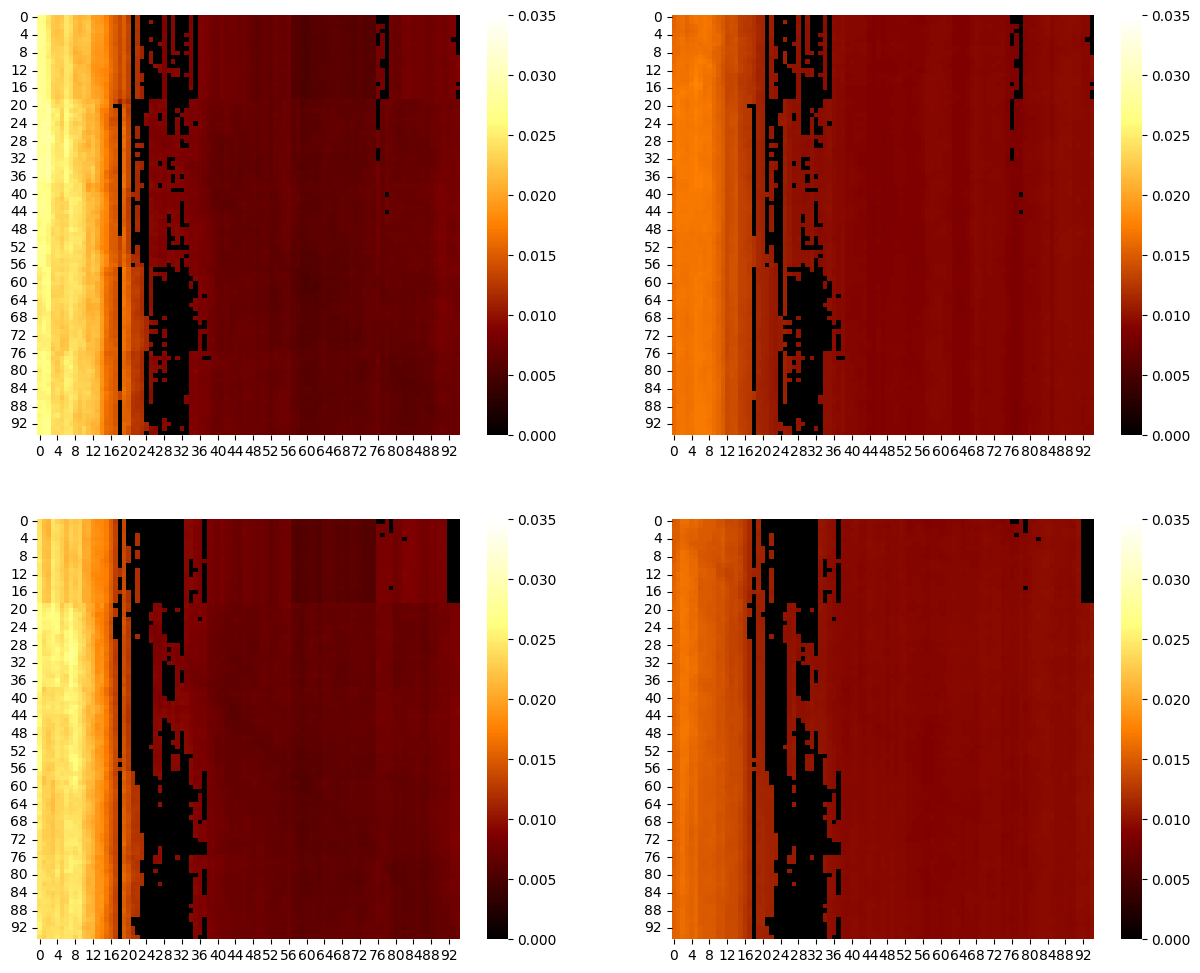

In [14]:
# Fuzzy-Right-Transformer-Right

vmin, vmax = 0, 0.035

fuzzy_res = fuzzy_output['res']
trans_res = trans_output['res']

fuzzy_res['check'] = fuzzy_res['label'] == fuzzy_res['pred']
trans_res['check'] = trans_res['label'] == trans_res['pred']
# select which transformer model is incorrect and fuzzy model is correct. They are same length
fuzzy_res_right = fuzzy_res.loc[fuzzy_res['check'] == True].index
trans_res_wrong = trans_res.loc[trans_res['check'] == True].index

selected_idxes = np.intersect1d(fuzzy_res_right, trans_res_wrong)

trans_selected_atts = trans_output['atts'][selected_idxes].mean(axis=2)
fuzzy_selected_atts = fuzzy_output['atts'][selected_idxes].mean(axis=2)

# t-matrix
t_matrix = np.empty(trans_selected_atts.shape[1:])
p_matrix = np.empty(trans_selected_atts.shape[1:])
for i in range(95):
    for j in range(95):
        for k in range(2):
            stat = pg.ttest(trans_selected_atts[:,k,i,j], fuzzy_selected_atts[:,k,i,j])
            t_matrix[k,i,j] = stat['T'].values
            p_matrix[k,i,j] = stat['p-val'].values

p = einops.rearrange(p_matrix, 'k i j -> (k i j)')
reject, p_corrected, _, _ = multipletests(p, alpha=0.05, method='bonferroni')
p_corrected = einops.rearrange(p_corrected, '(k i j) -> k i j', k=2, i=p_matrix.shape[1], j=p_matrix.shape[2])
reject = einops.rearrange(reject, '(k i j) -> k i j', k=2, i=p_matrix.shape[1], j=p_matrix.shape[2])
mask = reject.astype(int)
plt.figure(figsize=(15, 12))
ax = plt.subplot(2, 2, 1)
sns.heatmap(fuzzy_selected_atts[:,0].mean(0)*mask[0], ax=ax, vmin=vmin, vmax=vmax, cmap=cmap)
ax = plt.subplot(2, 2, 2)
sns.heatmap(trans_selected_atts[:,0].mean(0)*mask[0], ax=ax, vmin=vmin, vmax=vmax, cmap=cmap)
ax = plt.subplot(2, 2, 3)
sns.heatmap(fuzzy_selected_atts[:,1].mean(0)*mask[1], ax=ax, vmin=vmin, vmax=vmax, cmap=cmap)
ax = plt.subplot(2, 2, 4)
sns.heatmap(trans_selected_atts[:,1].mean(0)*mask[1], ax=ax, vmin=vmin, vmax=vmax, cmap=cmap)

plt.savefig('../output/fuzzy-right-transformer-right.svg')

/data/xiaowjia/miniconda3/envs/dl_pl/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:7321: RuntimeWarning: invalid value encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/data/xiaowjia/miniconda3/envs/dl_pl/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:7313: RuntimeWarning: invalid value encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)


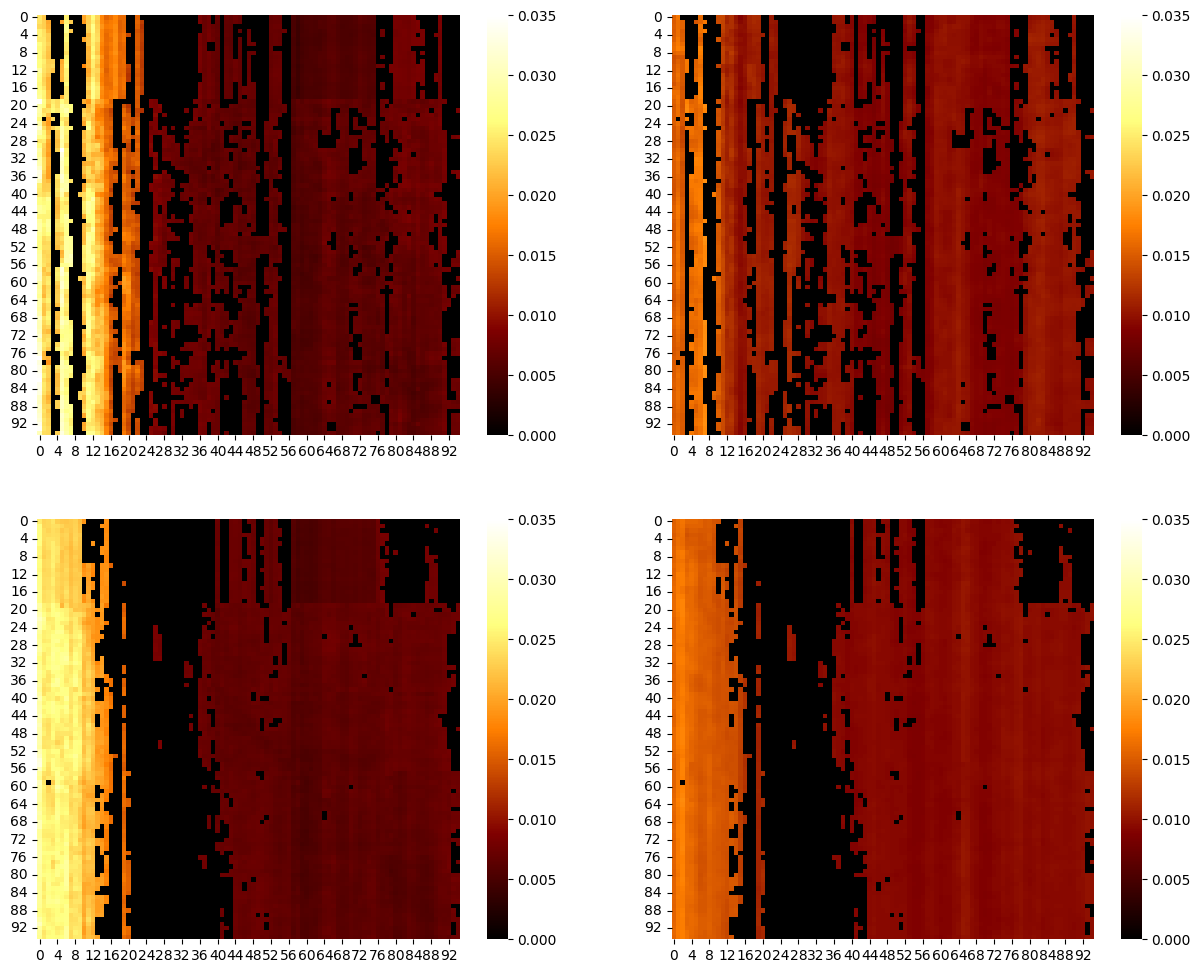

In [15]:
# Fuzzy-wrong-Transformer-wrong

vmin, vmax = 0, 0.035

fuzzy_res = fuzzy_output['res']
trans_res = trans_output['res']

fuzzy_res['check'] = fuzzy_res['label'] == fuzzy_res['pred']
trans_res['check'] = trans_res['label'] == trans_res['pred']
# select which transformer model is incorrect and fuzzy model is correct. They are same length
fuzzy_res_right = fuzzy_res.loc[fuzzy_res['check'] == False].index
trans_res_wrong = trans_res.loc[trans_res['check'] == False].index

selected_idxes = np.intersect1d(fuzzy_res_right, trans_res_wrong)

trans_selected_atts = trans_output['atts'][selected_idxes].mean(axis=2)
fuzzy_selected_atts = fuzzy_output['atts'][selected_idxes].mean(axis=2)

# t-matrix
t_matrix = np.empty(trans_selected_atts.shape[1:])
p_matrix = np.empty(trans_selected_atts.shape[1:])
for i in range(95):
    for j in range(95):
        for k in range(2):
            stat = pg.ttest(trans_selected_atts[:,k,i,j], fuzzy_selected_atts[:,k,i,j])
            t_matrix[k,i,j] = stat['T'].values
            p_matrix[k,i,j] = stat['p-val'].values

p = einops.rearrange(p_matrix, 'k i j -> (k i j)')
reject, p_corrected, _, _ = multipletests(p, alpha=0.05, method='bonferroni')
p_corrected = einops.rearrange(p_corrected, '(k i j) -> k i j', k=2, i=p_matrix.shape[1], j=p_matrix.shape[2])
reject = einops.rearrange(reject, '(k i j) -> k i j', k=2, i=p_matrix.shape[1], j=p_matrix.shape[2])
mask = reject.astype(int)
plt.figure(figsize=(15, 12))
ax = plt.subplot(2, 2, 1)
sns.heatmap(fuzzy_selected_atts[:,0].mean(0)*mask[0], ax=ax, vmin=vmin, vmax=vmax, cmap=cmap)
ax = plt.subplot(2, 2, 2)
sns.heatmap(trans_selected_atts[:,0].mean(0)*mask[0], ax=ax, vmin=vmin, vmax=vmax, cmap=cmap)
ax = plt.subplot(2, 2, 3)
sns.heatmap(fuzzy_selected_atts[:,1].mean(0)*mask[1], ax=ax, vmin=vmin, vmax=vmax, cmap=cmap)
ax = plt.subplot(2, 2, 4)
sns.heatmap(trans_selected_atts[:,1].mean(0)*mask[1], ax=ax, vmin=vmin, vmax=vmax, cmap=cmap)

plt.savefig('../output/fuzzy-wrong-transformer-wrong.svg')